# This file is very similar to the ontology-creation file.
# It exists to visualize small parts of the ontology.

## Function for preprocessing

In [1]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Tokenize and lower case
    tokens = word_tokenize(text.lower())

    # Remove punctuation and filter out stopwords, then lemmatize
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in string.punctuation and token not in stop_words]

    # Remove numbers
    processed_tokens = [re.sub("[0-9]+", '', token) for token in processed_tokens]
    processed_tokens = list(filter(None, processed_tokens))

    # Allow only alphabetical values
    processed_tokens = [token for token in processed_tokens if token.isalpha()]

    # Create a list of sentences
    sentences = [processed_tokens]

    # Learn and apply bigram transformations
    bigram_phrases = Phrases(sentences, min_count=1, threshold=1)
    bigram = Phraser(bigram_phrases)
    bigram_tokens = bigram[sentences[0]]

    # Learn and apply trigram transformations
    trigram_phrases = Phrases(bigram_tokens, min_count=1, threshold=1)
    trigram = Phraser(trigram_phrases)
    trigram_tokens = trigram[bigram_tokens]

    return trigram_tokens


## Helper functions for the TF-IDF Calculation

In [2]:
from collections import defaultdict
import math

def compute_idf(documents):
    idf = defaultdict(int)
    total_docs = len(documents)

    for doc in documents:
        for word in set(doc):
            idf[word] += 1
    
    for word, val in idf.items():
        idf[word] = math.log(total_docs / float(val))
    
    return idf

In [3]:
from collections import Counter

def compute_tf(tokens):
    return Counter(tokens)

In [4]:
def compute_tfidf(tf, idf):
    tfidf = {}
    for word, val in tf.items():
        tfidf[word] = val * idf[word]
    return tfidf

## Preparations for the preprocessing and TF-IDF calculations

In [5]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('./databases/publications-database.db')

# Enable foreign key support
conn.execute("PRAGMA foreign_keys = ON")

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

cursor.execute('''
    SELECT * FROM Publication
''')

publications = cursor.fetchall()

corpus_titles = []
corpus_abstracts = []

for publication in publications:
    publication_title = publication[1]
    publication_abstract = publication[2]

    corpus_titles.append(publication_title)
    corpus_abstracts.append(publication_abstract)

## Calculating the TF-IDF values

In [6]:
# Preprocessing the texts

abstracts_tokens = [preprocess_text(text) for text in corpus_abstracts]
titles_tokens = [preprocess_text(text) for text in corpus_titles]

In [7]:
# Computing the tf values

abstracts_tf = [compute_tf(tokens) for tokens in abstracts_tokens]
titles_tf = [compute_tf(tokens) for tokens in titles_tokens]

In [8]:
# Computing the idf values

abstracts_idf = compute_idf(abstracts_tokens)
titles_idf = compute_idf(titles_tokens)

In [9]:
# Computing the tf-idf values

abstracts_tfidf = [compute_tfidf(tf, abstracts_idf) for tf in abstracts_tf]
titles_tfidf = [compute_tfidf(tf, titles_idf) for tf in titles_tf]

### Checking the results

In [10]:
print(dict(sorted(abstracts_tfidf[0].items(), key=lambda x: x[1], reverse=True)))
print(len(abstracts_tfidf[0]))

{'shear_zone': 48.96310948486503, 'colloid': 28.247623835237583, 'transport': 16.38858162445567, 'groundwater_flow': 16.32103649495501, 'uranine': 16.32103649495501, 'hydraulic': 15.347987429262247, 'tracer_test': 14.934742133835119, 'cfm': 14.123811917618792, 'fairly': 12.162153411595337, 'migration': 11.191137780031937, 'modelling': 10.519673691959945, 'numerical': 10.01810574663061, 'planned': 9.883284845218608, 'grimsel': 8.160518247477505, 'darcy': 8.160518247477505, 'packer': 8.160518247477505, 'flow': 7.834326487746855, 'bentonite': 7.4673710669175595, 'sealed': 7.4673710669175595, 'gradient': 7.29931748192131, 'breakthrough': 6.551080335043404, 'project': 6.409382379752489, 'somewhat': 6.36875877824945, 'field': 6.367941982666102, 'fractured': 6.081076705797669, 'hole': 5.762622974679134, 'radionuclides': 5.595568890015969, 'facilitated': 5.521460917862246, 'dipole': 5.521460917862246, 'circular': 5.27014648958134, 'confidence': 5.1647859739235145, 'picture': 5.115995809754082,

In [11]:
print(dict(sorted(titles_tfidf[3050].items(), key=lambda x: x[1], reverse=True)))
print(len(titles_tfidf[3050]))

{'hypersurface': 8.160518247477505, 'random': 5.762622974679134, 'extended': 5.521460917862246, 'tracking': 5.387929525237724, 'object': 5.1647859739235145, 'model': 2.713780875811195}
6


## Helper functions needed for the next step

In [12]:
from itertools import islice

def take_first_percentages(dictionary, percentages_to_take):
    num_entries = len(dictionary)
    num_to_take = math.ceil(num_entries * percentages_to_take)  # Calculate the number of entries to take, round up

    first_5_percent = dict(islice(dictionary.items(), num_to_take))
    return first_5_percent


In [13]:
# List of all chemical elements (removed lead)
chemical_elements = [
    "Hydrogen", "Helium", "Lithium", "Beryllium", "Boron", "Carbon", "Nitrogen",
    "Oxygen", "Fluorine", "Neon", "Sodium", "Magnesium", "Aluminum", "Silicon",
    "Phosphorus", "Sulfur", "Chlorine", "Argon", "Potassium", "Calcium", "Scandium",
    "Titanium", "Vanadium", "Chromium", "Manganese", "Iron", "Cobalt", "Nickel",
    "Copper", "Zinc", "Gallium", "Germanium", "Arsenic", "Selenium", "Bromine",
    "Krypton", "Rubidium", "Strontium", "Yttrium", "Zirconium", "Niobium", "Molybdenum",
    "Technetium", "Ruthenium", "Rhodium", "Palladium", "Silver", "Cadmium", "Indium",
    "Tin", "Antimony", "Tellurium", "Iodine", "Xenon", "Cesium", "Barium", "Lanthanum",
    "Cerium", "Praseodymium", "Neodymium", "Promethium", "Samarium", "Europium",
    "Gadolinium", "Terbium", "Dysprosium", "Holmium", "Erbium", "Thulium", "Ytterbium",
    "Lutetium", "Hafnium", "Tantalum", "Tungsten", "Rhenium", "Osmium", "Iridium",
    "Platinum", "Gold", "Mercury", "Thallium", "Bismuth", "Polonium",
    "Astatine", "Radon", "Francium", "Radium", "Actinium", "Thorium", "Protactinium",
    "Uranium", "Neptunium", "Plutonium", "Americium", "Curium", "Berkelium",
    "Californium", "Einsteinium", "Fermium", "Mendelevium", "Nobelium", "Lawrencium",
    "Rutherfordium", "Dubnium", "Seaborgium", "Bohrium", "Hassium", "Meitnerium",
    "Darmstadtium", "Roentgenium", "Copernicium", "Nihonium", "Flerovium",
    "Moscovium", "Livermorium", "Tennessine", "Oganesson"
]

In [14]:
import csv

chemistry_csv = 'databases/chemistry.csv'
computer_science_csv = 'databases/computer-science.csv'

chemistry_competencies_list = []
computer_science_competencies_list = []

# Reading all competencies from the csv files
with open(chemistry_csv, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        chemistry_competencies_list.append(row)

with open(computer_science_csv, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        computer_science_competencies_list.append(row)

# Saving competencies into lists and adding all chemical elements
chemistry_competencies = chemistry_competencies_list[0] + chemical_elements
computer_science_competencies = computer_science_competencies_list[0]

# Lowercase all competencies
chemistry_competencies = [element.lower() for element in chemistry_competencies]
computer_science_competencies = [element.lower() for element in computer_science_competencies]

# Function to return the competencies that are in a given text
def get_competencies(publication_text):
    competencies = []
    for competency in chemistry_competencies:
        if re.search(r'\b' + re.escape(competency) + r'\b', publication_text):
            competencies.append(competency)
    
    for competency in computer_science_competencies:
        if re.search(r'\b' + re.escape(competency) + r'\b', publication_text):
            competencies.append(competency)
    
    return competencies

## Functions to add instances and relations to the ontology

### Creating the ontology

In [15]:
from rdflib import Graph, Literal, BNode, Namespace, RDF, URIRef
from rdflib.namespace import DC, FOAF

# Creating an RDF graph and namespace
g = Graph()
n  = Namespace("urn:semantic_search:")

# Creating Classes of the ontology
class_author = URIRef(n + "Author")
class_publication = URIRef(n + "Publication")
class_competency = URIRef(n + "Competency")

# Creating Relations for the classes
written_by = URIRef(n + "Written_by")
derived_from = URIRef(n + "Derived_from")


### Classes

In [105]:
# function to add a new publication, it is checked if the publication already exists, returns the publication in the ontology
def add_publication(graph, publication_id, publication_title, publication_abstract, publication_year):
    new_publication = URIRef(n + f"Publication:{publication_id}") 
    # Check if publication already exists in the graph
    if (new_publication, RDF.type, class_publication) in graph:
        return new_publication
    else:
        graph.add((new_publication, RDF.type, class_publication))
        graph.add((new_publication, URIRef(n + "publications:title"), Literal(publication_title)))
        graph.add((new_publication, URIRef(n + "publications:year"), Literal(publication_year)))
        return new_publication


In [17]:
# function to add a new author, it is checked if the author already exists, returns the author in the ontology
def add_author(graph, author_id, first_name, last_name):
    new_author = URIRef(n + f"Author:{author_id}") 
    # Check if author already exists in the graph
    if (new_author, RDF.type, class_author) in graph:
        return new_author
    else:
        graph.add((new_author, RDF.type, class_author))
        graph.add((new_author, URIRef(n + "authors:firstName"), Literal(first_name)))
        graph.add((new_author, URIRef(n + "authors:lastName"), Literal(last_name)))
        return new_author


In [18]:
# function to add a new competency, it is checked if the competency already exists, returns the competency in the ontology
def add_competency(graph, competency_name):
    competency_name = competency_name.replace(" ", "_")
    new_competency = URIRef(n + f"Competency:{competency_name}") 
    # Check if competency already exists in the graph
    if (new_competency, RDF.type, class_competency) in graph:
        return new_competency
    else:
        graph.add((new_competency, RDF.type, class_competency))
        graph.add((new_competency, URIRef(n + "competencies:name"), Literal(competency_name)))
        return new_competency


### Relations

In [161]:
# function to add a written by relation
def add_written_by(graph, author_id, publication_id):
    author = URIRef(n + f"Author:{author_id}") 
    publication = URIRef(n + f"Publication:{publication_id}")
    
    # Ensure that both the author and publication exist in the graph
    if (author, RDF.type, class_author) in graph and (publication, RDF.type, class_publication) in graph:
        graph.add((publication, written_by, author))
        return True
    else:
        raise IOError("Author or publication do not exist")

In [20]:
# function to add a has competency relation
def add_extraction(graph, publication_id, competency_name, certainty):
    publication = URIRef(n + f"Publication:{publication_id}")
    competency = URIRef(n + f"Competency:{competency_name}")
    new_dynamic_derived_from = URIRef(n + f"Extraction:{publication_id}-{competency_name}-{certainty}")

    assert 0 <= certainty <= 1

    # Ensure that both the publication and competency exist in the graph before creating the relationship
    if (publication, RDF.type, class_publication) in graph and (competency, RDF.type, class_competency) in graph:
        
        # Searching for a potentially existing extraction with of the same competency from the same publication
        query_str = f"""
            SELECT ?predicate WHERE {{
                <{competency}> ?predicate <{publication}> .
                FILTER(STRSTARTS(STR(?predicate), "{n}Extraction:{publication_id}-{competency_name}-"))
            }}
            """

        old_dynamic_derived_from = list(graph.query(query_str))

        # Check if extraction already exists in the graph
        if old_dynamic_derived_from:
            old_dynamic_derived_from = old_dynamic_derived_from[0][0]
            old_certainty = float(str(old_dynamic_derived_from).rsplit('-', 1)[-1])  # Extract the old certainty from the URI

            if old_certainty < int(certainty):
                # The extraction is updated with the new higher certainty
                graph.remove((competency, old_dynamic_derived_from, publication))
                graph.add((competency, new_dynamic_derived_from, publication))
                return new_dynamic_derived_from
            else:
                # The old certainty is higher and therefore the extraction is unchanged
                return old_dynamic_derived_from
        else:
            # Add new extraction to the graph
            graph.add((competency, new_dynamic_derived_from, publication))
            return new_dynamic_derived_from
    else:
        raise IOError("Publication or Competency do not exist")

    

### Adding the publications, authors and competencies to the ontology

### All Publications

In [168]:
import sqlite3
import statistics
import re
from tqdm import tqdm

allowed_competency_pattern = r'^[A-Za-z_]+$'
DEFAULT_TITLE_CERTAINTY = 0.7
DEFAULT_ABSTRACT_CERTAINTY = 0.2

# Creating an RDF graph and namespace
g = Graph()

# Preparation for result checking
csv_comps = []
tf_idf_comps_abstracts = []
tf_idf_comps_titles = []

# Creating the ontology from the SQL database of publications
# Connect to the database
conn = sqlite3.connect('databases/publications-database.db')

# Enable foreign key support
conn.execute("PRAGMA foreign_keys = ON")

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

cursor.execute('''
    SELECT * FROM Publication
''')

publications = cursor.fetchall()

for publication in [publications[2147], publications[3081]]:
    publication_id = publication[0]
    publication_title = publication[1]
    publication_abstract = publication[2]
    publication_year = publication[3]

    publication_onto = add_publication(g, publication_id, publication_title, publication_abstract, publication_year)

    # Handling the authors of the publication

    cursor.execute('''
        SELECT Author.author_id, first_name, last_name FROM
                    Author JOIN written_by ON written_by.author_id = Author.author_id
                   WHERE written_by.publication_id = ?
                   ''', [publication_id])
    
    authors = cursor.fetchall()

    for author in authors:
        author_id = author[0]
        author_first_name = author[1]
        author_last_name = author[2]

        author_onto = add_author(g, author_id, author_first_name, author_last_name)

        written_by_onto = add_written_by(g, author_id, publication_id)

    # Handling all the competencies the publications contains

    # Handling the competencies from the competencies csv files
    # First for the titles
    competencies_csv_titles = get_competencies(publication_title)
    csv_comps = csv_comps + competencies_csv_titles # For result checking afterwards
    for title_competency in competencies_csv_titles:
        title_competency = title_competency.replace(" ", "_")
        competency_onto = add_competency(g, title_competency)

        has_competency_onto = add_extraction(g, publication_id, title_competency, DEFAULT_TITLE_CERTAINTY)
    # Then for the abstracts
    competencies_csv_abstracts = get_competencies(publication_abstract)
    csv_comps = csv_comps + competencies_csv_abstracts # For result checking afterwards
    for abstract_competency in competencies_csv_abstracts:
        abstract_competency = abstract_competency.replace(" ", "_")
        competency_onto = add_competency(g, abstract_competency)

        has_competency_onto = add_extraction(g, publication_id, abstract_competency, DEFAULT_ABSTRACT_CERTAINTY)
    

    # Handling the tf-idf competencies

    # Sorting the competencies from the abstracts by the TF-IDF value in descending order
    sorted_tf_idf_abstracts_dict = dict(sorted(abstracts_tfidf[publication_id].items(), key=lambda x: x[1], reverse=True))
    tf_idf_competencies_abstract = take_first_percentages(sorted_tf_idf_abstracts_dict, 0.05) # the top 0.05 competencies are chosen

    # Sorting the competencies from the titles by the TF-IDF value in descending order
    sorted_tf_idf_titles_dict = dict(sorted(titles_tfidf[publication_id].items(), key=lambda x: x[1], reverse=True))
    tf_idf_competencies_titles = take_first_percentages(sorted_tf_idf_titles_dict, 0.1) # the top 0.1 competencies are chosen

    # For result checking afterwards
    tf_idf_comps_abstracts = tf_idf_comps_abstracts + list(tf_idf_competencies_abstract.keys())
    tf_idf_comps_titles = tf_idf_comps_titles + list(tf_idf_competencies_titles.keys())

    # Adding the competencies from the titles
    for competency in tf_idf_competencies_titles:
        competency = competency.replace(" ", "_")
        if re.match(allowed_competency_pattern, competency) is not None:
            added_competency = add_competency(g, competency)
            added_extraction = add_extraction(g, publication_id, competency, 1) # Using certainty 1 for competencies from titles
    
    max_tf_idf_value = max(tf_idf_competencies_abstract.values())
    # For the min value the mean of all tf-idf values of the abstract is used. 
    # This ensures that the certainties are strictly above 0
    min_tf_idf_value = min(tf_idf_competencies_abstract.values()) - statistics.mean(tf_idf_competencies_abstract.values())
    
    # Adding the competencies from the abstracts
    for competency in tf_idf_competencies_abstract:
        competence_tf_idf_value = tf_idf_competencies_abstract[competency]

        # Normalizing the TF-IDF values with the min-max normalization
        if min_tf_idf_value != max_tf_idf_value:
            competency_certainty = (competence_tf_idf_value - min_tf_idf_value) / (max_tf_idf_value - min_tf_idf_value)
        else:
            competency_certainty = 1
        
        competency = competency.replace(" ", "_")
        if re.match(allowed_competency_pattern, competency) is not None:
            added_competency = add_competency(g, competency)
            added_extraction = add_extraction(g, publication_id, competency, competency_certainty)


# Save the graph to an XML file
g.serialize(destination='../ontology/semantic-search-ontology-visualization.rdf', format='xml')


2720 2147
2721 2147
2722 2147
2720 3081
2721 3081


<Graph identifier=N7efc6772d1f142e5a6a28d28c42816b1 (<class 'rdflib.graph.Graph'>)>

In [88]:
# Function to extract content after the last occurrence of either ':' or '-'
def extract_label(uri):
    if 'Publication' in uri or 'Author' in uri:
        parts = uri.split(":")
        if len(parts) >= 2:
            return ":".join(parts[-2:])
        return uri
    last_colon = uri.rfind(':')
    last_hyphen = uri.rfind('-')
    
    # Find the position of the last occurrence of either character
    split_pos = max(last_colon, last_hyphen)
    
    label = uri[split_pos + 1:]

    try:
        label = float(label)
        return str(round(label, 3))
    except ValueError:
        pass

    # Return the substring after the found position
    return label

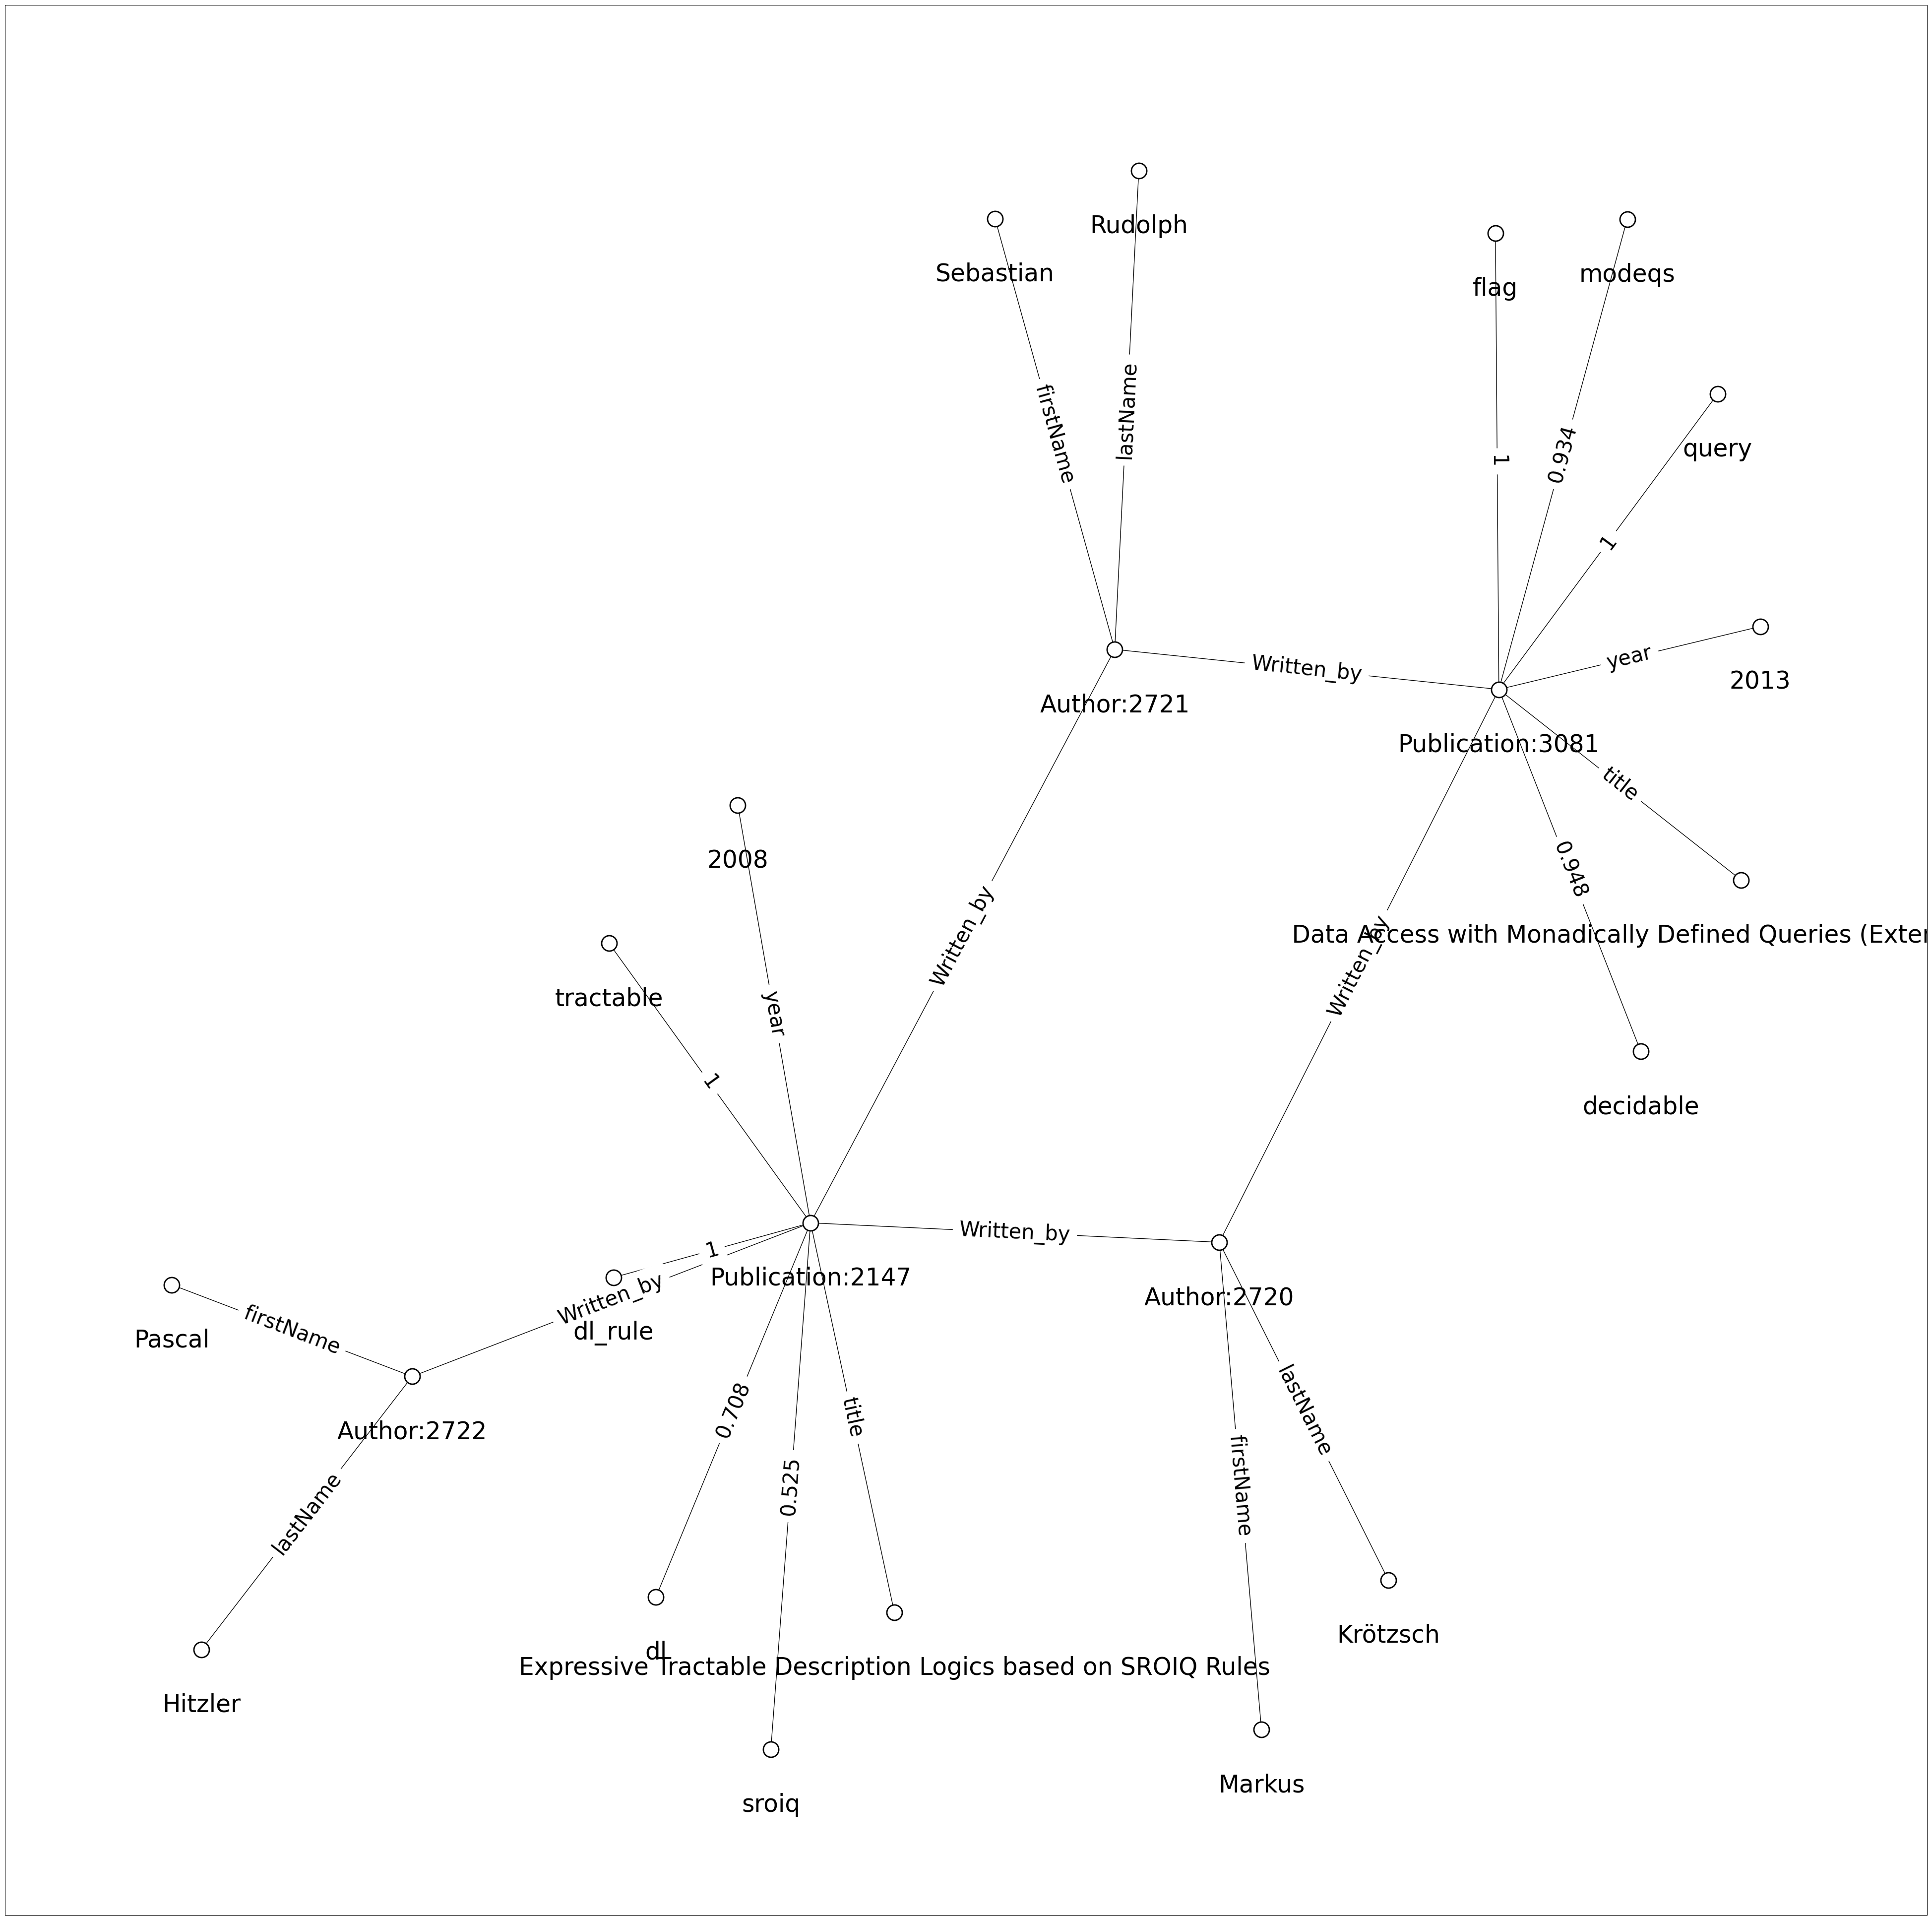

In [172]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, RDF

# Function to extract content after the last occurrence of either ':' or '-'
def extract_label(uri):
    if 'Publication' in uri or 'Author' in uri:
        parts = uri.split(":")
        if len(parts) >= 2:
            return ":".join(parts[-2:])
        return uri
    last_colon = uri.rfind(':')
    last_hyphen = uri.rfind('-')
    
    # Find the position of the last occurrence of either character
    split_pos = max(last_colon, last_hyphen)
    
    label = uri[split_pos + 1:]

    try:
        label = float(label)
        if label.is_integer():
            return str(int(label))
        return str(round(label, 3))
    except ValueError:
        pass

    # Return the substring after the found position
    return label

# Load RDF graph
g = Graph()
g.parse('../ontology/semantic-search-ontology-visualization.rdf', format='xml')

# Create a NetworkX graph
G = nx.Graph()

# Add nodes and edges to NetworkX graph based on RDF graph
edge_labels = {}
for s, p, o in g:
    # Skip triples with rdf.type as predicate
    # Also skip relations that begin with "urn:semantic_search:competencies:name"
    if p == RDF.type or str(p).startswith("urn:semantic_search:competencies:name"):
        continue
    
    s_str, p_str, o_str = extract_label(str(s)), extract_label(str(p)), extract_label(str(o))
    if p_str == '0.5':
        continue
    G.add_edge(s_str, o_str)
    edge_labels[(s_str, o_str)] = p_str

# Set the size of the figure
plt.figure(figsize=(50, 50))

# Draw the graph with increased node spacing
pos = nx.spring_layout(G, k=0.22)

# Draw nodes with black border, white fill, and larger size
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', linewidths=2, node_size=500)  # Adjust node_size as needed

# Draw edges in black
nx.draw_networkx_edges(G, pos, edge_color='black')

# Adjust label positions to make them appear slightly below the vertices
label_pos = {node: (x, y - 0.03) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=35, font_color='black')  # Set label color to black

# Draw edge labels (relations/predicates) in black
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=30, font_color='black')  # Set edge label color to black

# Save the figure
plt.savefig('../ontology/images/ontology-visualization-2-publications-author-overlap.png', bbox_inches='tight')

plt.show()